In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

C:\Users\Vatsal\AppData\Local\Continuum\anaconda3\envs\gputest\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [5]:
df = pd.read_csv(r'C:\Users\Vatsal\Documents\Python Scripts\Credit Card Fraud\creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.isnull().sum().max()

0

In [7]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

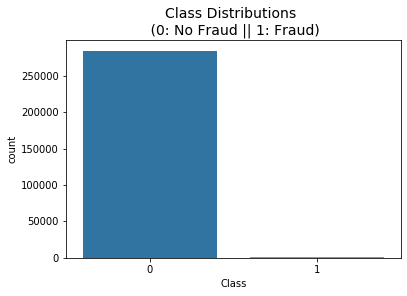

In [8]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

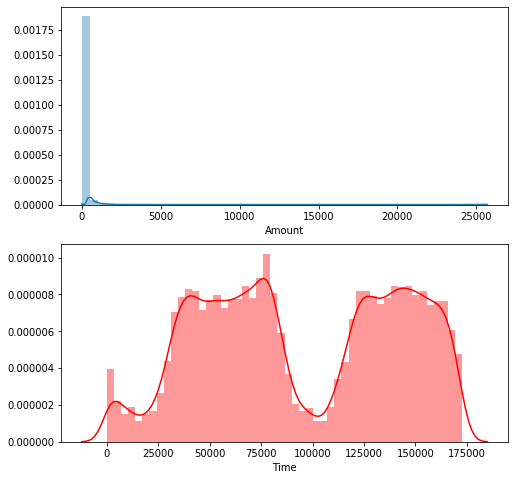

In [9]:
fig, ax = plt.subplots(2, 1,figsize=(8,8))
sns.distplot(df['Amount'],ax=ax[0],bins=50)
sns.distplot(df['Time'],bins=50,ax=ax[1],color='r')

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

scaled_amount = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [11]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
X = df.drop('Class',axis=1)
y = df['Class']
sss = StratifiedKFold(n_splits=5,random_state=111,shuffle=False)
for train_index, test_index in sss.split(X,y):
    print('Train : ',train_index,'Test : ',test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)
print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))    

Train :  [ 30473  30496  31002 ... 284804 284805 284806] Test :  [    0     1     2 ... 57017 57018 57019]
Train :  [     0      1      2 ... 284804 284805 284806] Test :  [ 30473  30496  31002 ... 113964 113965 113966]
Train :  [     0      1      2 ... 284804 284805 284806] Test :  [ 81609  82400  83053 ... 170946 170947 170948]
Train :  [     0      1      2 ... 284804 284805 284806] Test :  [150654 150660 150661 ... 227866 227867 227868]
Train :  [     0      1      2 ... 227866 227867 227868] Test :  [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [12]:
df= df.sample(frac=1)
fraud_df = df.loc[df['Class']==1]
non_fraud_df = df.loc[df['Class']==0][:492]
normal_distributed_df = pd.concat([fraud_df,non_fraud_df])
new_df = normal_distributed_df.sample(frac=1,random_state=111)
new_df.head(10)

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
52845,0.181513,-0.458382,-0.929097,0.310395,2.286244,-0.846111,-0.612453,-1.010593,0.144185,0.011595,0.234695,-0.720375,-0.440227,-0.571312,-0.952683,-0.043270,0.917060,0.766181,-0.591312,0.156168,-0.932536,-0.191398,0.239456,0.584245,-0.198979,0.776541,-0.269445,0.927214,-0.077069,0.081687,0
92332,3.793055,-0.244470,0.741293,-0.821956,-1.621517,0.174944,1.972514,3.395409,0.023158,0.689324,-0.187383,-0.060003,-0.157875,0.040578,0.028513,0.590595,1.140654,0.411948,-0.918553,0.349022,-0.090927,0.570256,0.149733,-0.328367,-0.389939,1.018844,0.741671,-0.343680,-0.038339,0.063903,0
40085,-0.293440,-0.524043,1.083693,1.179501,-1.346150,1.998824,0.818034,-0.771419,0.230307,0.093683,-0.167594,-1.959809,2.804335,0.312424,-0.595976,-4.662577,-0.299515,1.001414,3.902825,1.619609,-0.888087,-0.060159,-0.312000,-0.639700,-0.120249,-0.180218,0.609283,-0.339524,0.096701,0.114972,1
153835,-0.293440,0.183343,-22.341889,15.536133,-22.865228,7.043374,-14.183129,-0.463145,-28.215112,-14.607791,-9.481456,-20.949192,4.739582,-11.924955,-1.501411,-3.836781,-2.720329,-8.880106,-15.825136,-6.750425,-0.129188,4.100019,-9.110423,4.158895,1.412928,0.382801,0.447154,-0.632816,-4.380154,-0.467863,1
59287,0.805422,-0.421939,-0.825667,0.932699,0.714879,-0.039670,-0.410532,-0.248206,0.448721,0.300085,-0.716783,-0.316650,1.033769,1.305388,1.192547,0.303350,-0.005258,0.680305,-0.744179,0.127010,0.400412,-0.249275,-0.141336,-0.487243,0.347452,-0.001613,-0.564171,-0.085624,-0.271352,-0.085444,0
1586,1.928317,-0.980463,0.989275,-0.729341,-0.593078,-1.527905,-0.289611,-0.667475,0.277676,-0.124736,0.811585,-0.940543,1.494490,1.097025,-0.381902,0.797213,1.114241,-0.711640,-0.100079,-0.098741,0.831006,0.193967,0.109294,0.075874,-0.266619,-0.241894,0.574936,0.030913,-0.039799,0.014318,0
28317,-0.107874,-0.584382,0.991187,-0.522331,1.163757,0.108107,-0.490345,1.482555,-0.926545,0.591819,1.059343,-0.666947,0.574961,1.428336,0.540555,-0.552852,0.687029,-1.513392,1.427465,-2.774176,-1.214681,-0.168550,-0.081346,0.197216,0.234864,-0.530012,-0.200387,1.047581,0.041587,0.005469,0
91991,-0.205408,-0.246396,-3.773014,3.201668,-0.322983,-2.221897,-0.765573,-0.357056,0.041866,0.652371,2.575003,3.771013,1.337927,0.582175,-0.527128,-0.651986,0.342384,0.415441,-0.814333,-0.368344,-1.129875,1.740654,-0.477002,-0.422692,0.158987,-0.340690,0.392535,0.794667,1.360243,0.625234,0
108200,-0.279746,-0.163113,-1.330986,0.701437,1.021661,0.065193,0.116626,-0.534211,0.171269,0.414623,-0.295169,-0.104577,1.609548,0.058737,-1.414841,0.116528,0.632948,0.335373,0.228343,0.025586,-0.176568,-0.188267,-0.211959,-0.489759,0.456253,0.125020,-0.261935,0.042217,-0.271248,-0.186126,0
243393,-0.307273,0.789765,-5.488032,3.329561,-5.996296,3.601720,-2.023926,-1.737393,-4.396859,0.228394,-1.675884,-3.991785,3.737038,-6.150187,0.288738,-8.760695,2.344651,-5.145638,-6.293479,-2.137187,2.995245,-0.551121,1.719631,0.343209,0.133584,0.833340,-0.839776,0.502010,-1.937473,1.521218,1


Fraud Percentage :  0.5


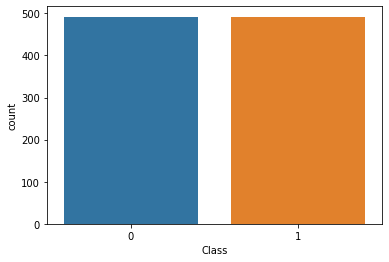

In [13]:
print("Fraud Percentage : ",(sum(new_df['Class']==1)/len(new_df)))
sns.countplot(x='Class',data=new_df)

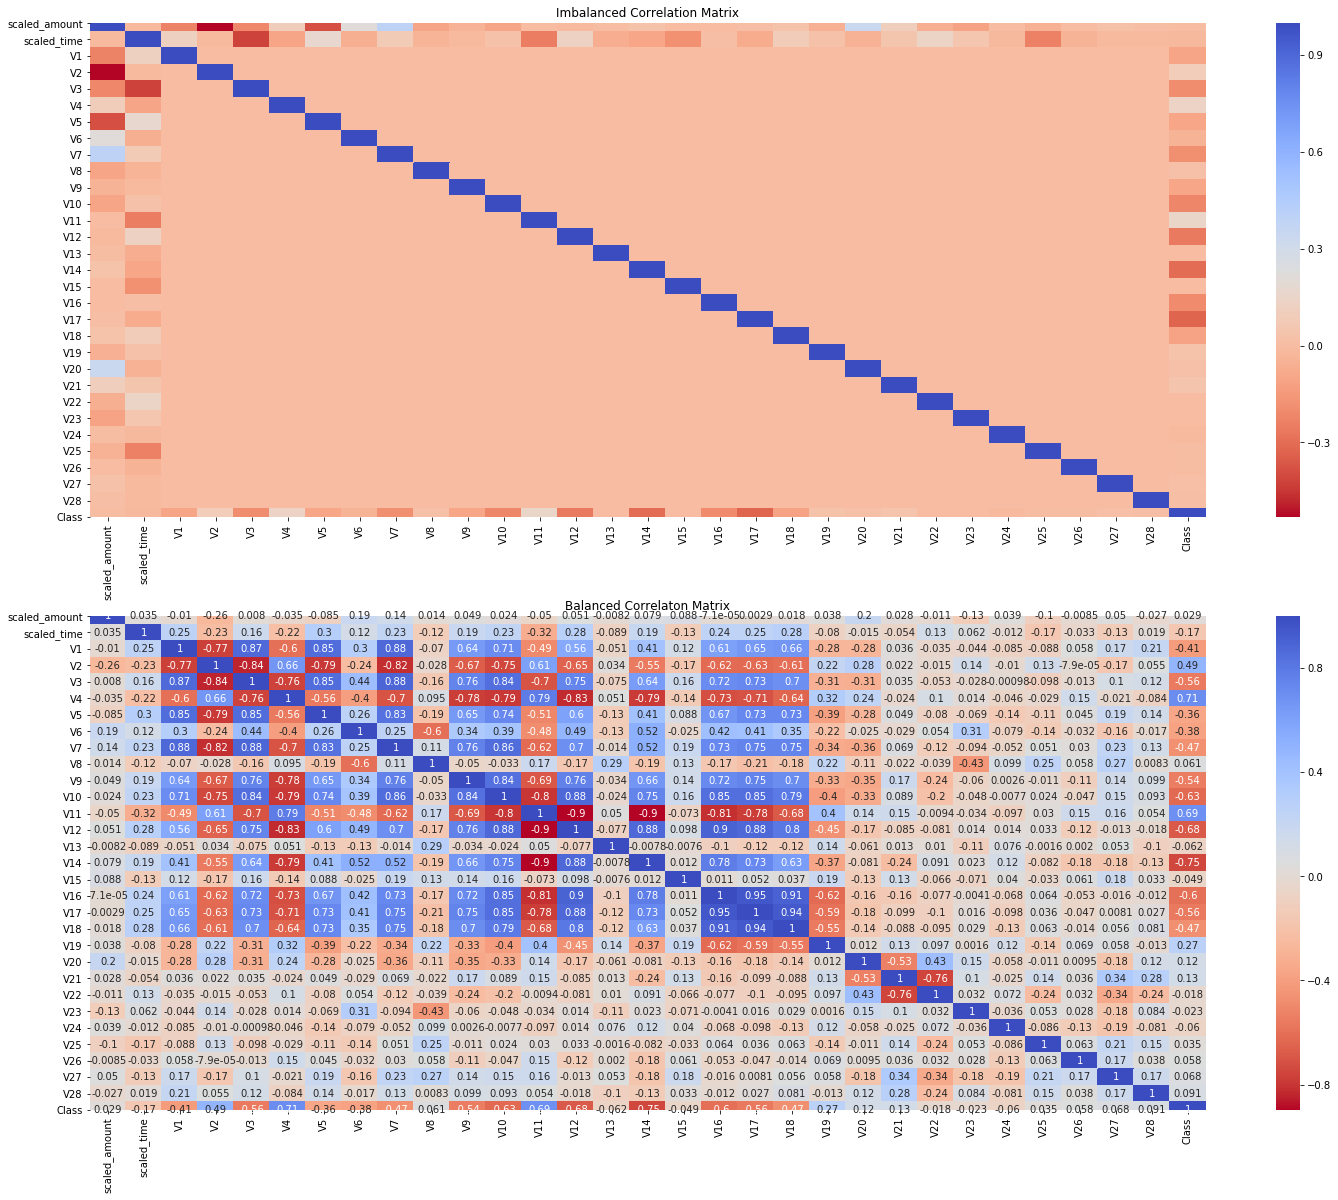

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(25,20))

corr=df.corr()
sns.heatmap(data=corr,cmap='coolwarm_r',ax=ax1)
ax1.set_title('Imbalanced Correlation Matrix')

sample_corr = new_df.corr()
sns.heatmap(data=sample_corr,cmap='coolwarm_r',ax=ax2,annot=True)
ax2.set_title('Balanced Correlaton Matrix')

plt.show()

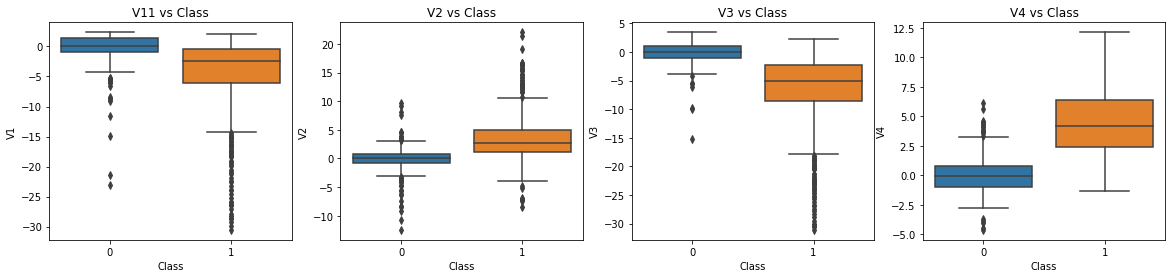

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V1", data=new_df, ax=ax[0])
ax[0].set_title('V11 vs Class')

sns.boxplot(x="Class", y="V2", data=new_df, ax=ax[1])
ax[1].set_title('V2 vs Class')

sns.boxplot(x="Class", y="V3", data=new_df, ax=ax[2])
ax[2].set_title('V3 vs Class')

sns.boxplot(x="Class", y="V4", data=new_df, ax=ax[3])
ax[3].set_title('V4 vs Class')

plt.show()

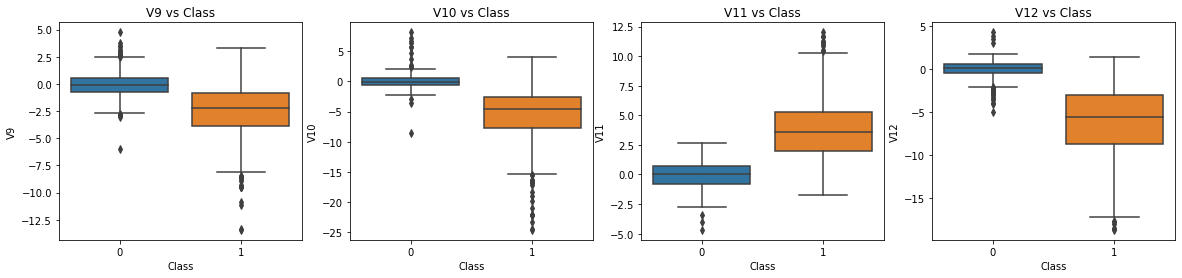

In [16]:
fig, ax = plt.subplots(ncols=4 ,figsize=(20,4))

sns.boxplot(x="Class", y="V9", data=new_df, ax=ax[0])
ax[0].set_title('V9 vs Class')

sns.boxplot(x="Class", y="V10", data=new_df, ax=ax[1])
ax[1].set_title('V10 vs Class')

sns.boxplot(x="Class", y="V11", data=new_df, ax=ax[2])
ax[2].set_title('V11 vs Class')

sns.boxplot(x="Class", y="V12", data=new_df, ax=ax[3])
ax[3].set_title('V12 vs Class')

plt.show()

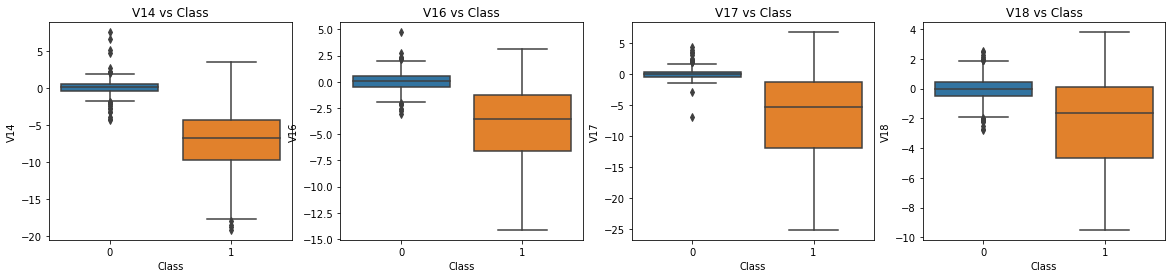

In [17]:
fig, ax = plt.subplots(ncols=4 ,figsize=(20,4))

sns.boxplot(x="Class", y="V14", data=new_df, ax=ax[0])
ax[0].set_title('V14 vs Class')

sns.boxplot(x="Class", y="V16", data=new_df, ax=ax[1])
ax[1].set_title('V16 vs Class')

sns.boxplot(x="Class", y="V17", data=new_df, ax=ax[2])
ax[2].set_title('V17 vs Class')

sns.boxplot(x="Class", y="V18", data=new_df, ax=ax[3])
ax[3].set_title('V18 vs Class')

plt.show()

In [18]:
from scipy.stats import norm

Text(0.5, 1.0, 'V14 Distplot')

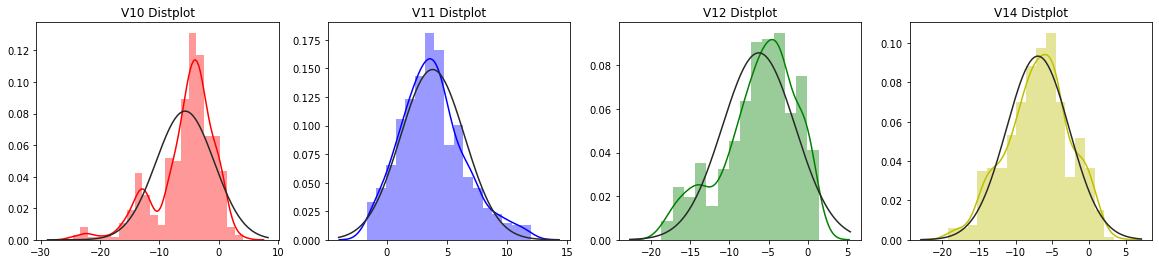

In [19]:
fig, ax = plt.subplots(ncols=4 ,figsize=(20,4))

v10_fraud = new_df['V10'].loc[new_df['Class']==1].values
sns.distplot(v10_fraud,fit=norm,ax=ax[0],color='r')
ax[0].set_title('V10 Distplot')

v11_fraud = new_df['V11'].loc[new_df['Class']==1].values
sns.distplot(v11_fraud,fit=norm,ax=ax[1],color='b')
ax[1].set_title('V11 Distplot')

v12_fraud = new_df['V12'].loc[new_df['Class']==1].values
sns.distplot(v12_fraud,fit=norm,ax=ax[2],color='g')
ax[2].set_title('V12 Distplot')

v14_fraud = new_df['V14'].loc[new_df['Class']==1].values
sns.distplot(v14_fraud,fit=norm,ax=ax[3],color='y')
ax[3].set_title('V14 Distplot')

In [20]:
#V14
print('V14')
q25, q75 = np.percentile(v14_fraud,25), np.percentile(v14_fraud,75)
print('First Quartile {}, Third Quartile'.format(q25,q75))
v14_iqr = q75 - q25
v14_cutoff = v14_iqr * 1.5
v14_low = q25 - v14_cutoff
v14_up = q75 + v14_cutoff
print("Cut Off: {}, Low: {}, High: {}".format(v14_cutoff,v14_low,v14_up))
outliers = [x for x in v14_fraud if x < v14_low or x > v14_up]
print("Outliers {}".format(outliers))
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))
new_df = new_df.drop(new_df[(new_df['V14'] > v14_up) | (new_df['V14'] < v14_low)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

V14
First Quartile -9.692722964972385, Third Quartile
Cut Off: 8.114853173228278, Low: -17.807576138200663, High: 3.8320323237414122
Outliers [-18.8220867423816, -18.4937733551053, -19.2143254902614, -18.049997689859396]
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.8220867423816, -18.4937733551053, -19.2143254902614, -18.049997689859396]
Number of Instances after outliers removal: 976


In [21]:
#V12
print('V12')
q25, q75 = np.percentile(v12_fraud,25), np.percentile(v12_fraud,75)
print('First Quartile {}, Third Quartile'.format(q25,q75))
v12_iqr = q75 - q25
v12_cutoff = v12_iqr * 1.5
v12_low = q25 - v12_cutoff
v12_up = q75 + v12_cutoff
print("Cut Off: {}, Low: {}, High: {}".format(v12_cutoff,v12_low,v12_up))
outliers = [x for x in v12_fraud if x < v12_low or x > v12_up]
print("Outliers {}".format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V12 outliers:{}'.format(outliers))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_up) | (new_df['V12'] < v12_low)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

V12
First Quartile -8.688176521812306, Third Quartile
Cut Off: 8.571132744641064, Low: -17.25930926645337, High: 5.597044719256134
Outliers [-17.631606313870698, -18.683714633344298, -18.4311310279993, -18.047596570821604, -17.7691434633638, -18.553697009645802]
Feature V12 Outliers for Fraud Cases: 6
V12 outliers:[-17.631606313870698, -18.683714633344298, -18.4311310279993, -18.047596570821604, -17.7691434633638, -18.553697009645802]
Number of Instances after outliers removal: 972


In [22]:
#V11
print('V11')
q25, q75 = np.percentile(v11_fraud,25), np.percentile(v11_fraud,75)
print('First Quartile {}, Third Quartile'.format(q25,q75))
v11_iqr = q75 - q25
v11_cutoff = v11_iqr * 1.5
v11_low = q25 - v11_cutoff
v11_up = q75 + v11_cutoff
print("Cut Off: {}, Low: {}, High: {}".format(v11_cutoff,v11_low,v11_up))
outliers = [x for x in v11_fraud if x < v11_low or x > v11_up]
print("Outliers {}".format(outliers))
print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V11 outliers:{}'.format(outliers))
new_df = new_df.drop(new_df[(new_df['V11'] > v11_up) | (new_df['V11'] < v11_low)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

V11
First Quartile 1.973396660607005, Third Quartile
Cut Off: 5.000521409233995, Low: -3.0271247486269903, High: 10.30759900933033
Outliers [10.446846814514, 11.277920727806698, 11.6197234753825, 11.0270590938161, 11.152490598583698, 10.5452629545898, 11.6692047358121, 12.018913181619899, 11.228470279576001, 10.8530116481991]
Feature V11 Outliers for Fraud Cases: 10
V11 outliers:[10.446846814514, 11.277920727806698, 11.6197234753825, 11.0270590938161, 11.152490598583698, 10.5452629545898, 11.6692047358121, 12.018913181619899, 11.228470279576001, 10.8530116481991]
Number of Instances after outliers removal: 966


In [23]:
#V10
print('V10')
q25, q75 = np.percentile(v10_fraud,25), np.percentile(v10_fraud,75)
print('First Quartile {}, Third Quartile'.format(q25,q75))
v10_iqr = q75 - q25
v10_cutoff = v10_iqr * 1.5
v10_low = q25 - v10_cutoff
v10_up = q75 + v10_cutoff
print("Cut Off: {}, Low: {}, High: {}".format(v10_cutoff,v10_low,v10_up))
outliers = [x for x in v10_fraud if x < v10_low or x > v10_up]
print("Outliers {}".format(outliers))
print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V11 outliers:{}'.format(outliers))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_up) | (new_df['V10'] < v10_low)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

V10
First Quartile -7.7566982278474725, Third Quartile
Cut Off: 7.713771471986866, Low: -15.47046969983434, High: 5.099587558797303
Outliers [-20.949191554361104, -18.9132433348732, -24.403184969972802, -17.141513641289198, -16.2556117491401, -22.1870885620007, -24.5882624372475, -15.563791338730098, -22.1870885620007, -16.6496281595399, -22.1870885620007, -19.836148851696, -15.563791338730098, -23.2282548357516, -18.2711681738888, -16.7460441053944, -16.3035376590131, -16.6011969664137, -22.1870885620007]
Feature V11 Outliers for Fraud Cases: 19
V11 outliers:[-20.949191554361104, -18.9132433348732, -24.403184969972802, -17.141513641289198, -16.2556117491401, -22.1870885620007, -24.5882624372475, -15.563791338730098, -22.1870885620007, -16.6496281595399, -22.1870885620007, -19.836148851696, -15.563791338730098, -23.2282548357516, -18.2711681738888, -16.7460441053944, -16.3035376590131, -16.6011969664137, -22.1870885620007]
Number of Instances after outliers removal: 941


Text(0.5, 1.0, 'V14 vs Class')

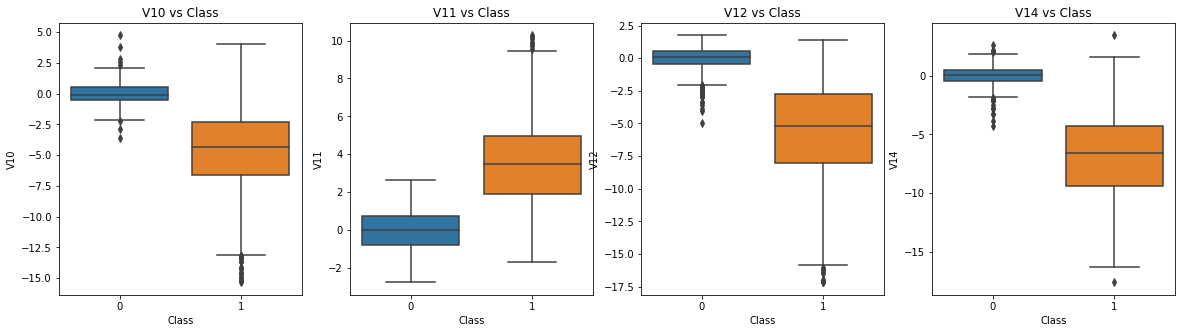

In [24]:
fig, ax = plt.subplots(ncols=4,figsize=(20,5))

sns.boxplot(x='Class',y='V10',data=new_df,ax=ax[0])
ax[0].set_title('V10 vs Class')

sns.boxplot(x='Class',y='V11',data=new_df,ax=ax[1])
ax[1].set_title('V11 vs Class')

sns.boxplot(x='Class',y='V12',data=new_df,ax=ax[2])
ax[2].set_title('V12 vs Class')

sns.boxplot(x='Class',y='V14',data=new_df,ax=ax[3])
ax[3].set_title('V14 vs Class')

In [25]:
X = new_df.drop('Class',axis=1)
y = new_df['Class']

#T-SNE
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2,random_state=111).fit_transform(X.values)
t1 = time.time()
print("T-SNE time taken {:.2}s".format(t1-t0))

#PCA
t0 = time.time()
X_reduced_pca = PCA(n_components=2,random_state=111).fit_transform(X.values)
t1 = time.time()
print("PCA time taken {:.2}s".format(t1-t0))

#T-SNE
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2,algorithm='randomized',random_state=111).fit_transform(X.values)
t1 = time.time()
print("TruncatedSVD time taken {:.2}s".format(t1-t0))


T-SNE time taken 2.8s
PCA time taken 0.051s
TruncatedSVD time taken 0.004s


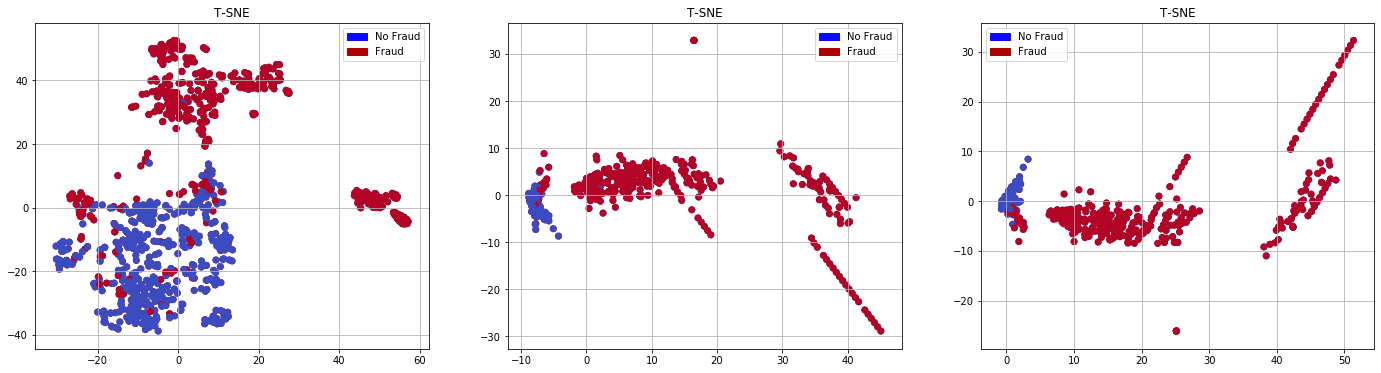

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0), cmap = 'coolwarm', label='No Fraud')
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap = 'coolwarm', label='Fraud')
ax1.set_title('T-SNE')
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==0), cmap = 'coolwarm', label='No Fraud')
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==1), cmap = 'coolwarm', label='Fraud')
ax2.set_title('T-SNE')
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==0), cmap = 'coolwarm', label='No Fraud')
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==1), cmap = 'coolwarm', label='Fraud')
ax3.set_title('T-SNE')
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

In [27]:
X = new_df.drop('Class',axis=1)
y = new_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [28]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [29]:
classifiers = {
    "LogisticRegression":LogisticRegression(),
    "KNearest":KNeighborsClassifier(),
    "Support Vector Machines":SVC(),
    "Decision Tree Classifier":DecisionTreeClassifier()
}

In [30]:
from sklearn.model_selection import cross_val_score
for key, classfier in classifiers.items():
    classfier.fit(X_train,y_train)
    training_score = cross_val_score(classfier,X_train,y_train,cv=5)
    print("Classifiers: ",classfier.__class__.__name__, "has a traning score of ", round(training_score.mean(),2)*100,"% accurcay")

Classifiers:  LogisticRegression has a traning score of  93.0 % accurcay
Classifiers:  KNeighborsClassifier has a traning score of  93.0 % accurcay
Classifiers:  SVC has a traning score of  93.0 % accurcay
Classifiers:  DecisionTreeClassifier has a traning score of  89.0 % accurcay


In [31]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [32]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.68%
Knears Neighbors Cross Validation Score 92.55%
Support Vector Classifier Cross Validation Score 93.48%
DecisionTree Classifier Cross Validation Score 92.68%


In [33]:
undersample_X = df.drop('Class',axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X,undersample_y):
    print("Train: {}\n Test: {}".format(train_index,test_index))
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values,undersample_y.values)
print('NearMiss Label Distribution : {}'.format(Counter(y_nearmiss)))

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'),log_reg)
    undersample_model = undersample_pipeline.fit(undersample_Xtrain,undersample_ytrain)
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test],original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 56946  56947  56948 ... 284804 284805 284806]
 Test: [    0     1     2 ... 65265 65645 65693]
Train: [     0      1      2 ... 284804 284805 284806]
 Test: [ 56946  56947  56948 ... 116982 117225 118319]
Train: [     0      1      2 ... 284804 284805 284806]
 Test: [113916 113917 113918 ... 171613 172384 172934]
Train: [     0      1      2 ... 284804 284805 284806]
 Test: [170881 170882 170883 ... 231999 232643 233336]
Train: [     0      1      2 ... 231999 232643 233336]
 Test: [227836 227837 227838 ... 284804 284805 284806]
NearMiss Label Distribution : Counter({0: 492, 1: 492})


In [34]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Vatsal\\AppData\\Local\\Continuum\\anaconda3\\envs\\gputest\\lib\\site-packages\\matplotlib\\pyplot.py'>

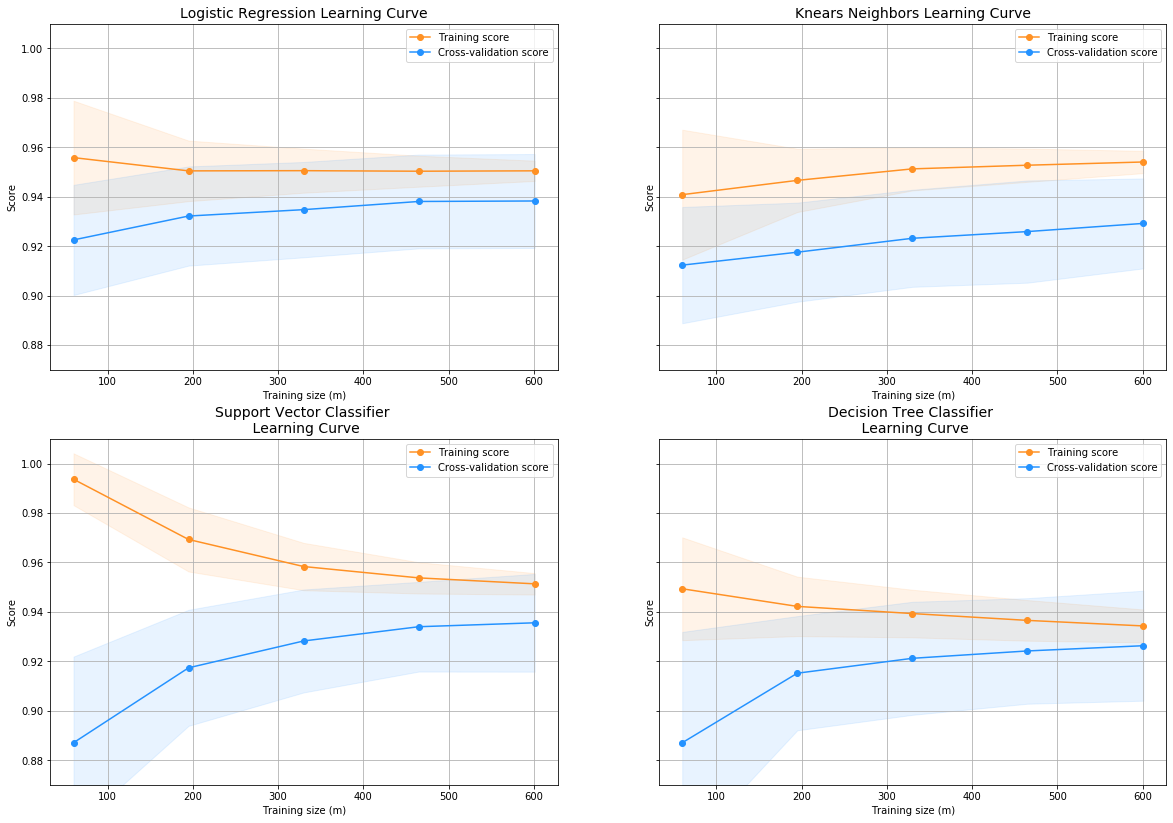

In [35]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [36]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
log_reg_pred = cross_val_predict(log_reg,X_train,y_train,cv=5,method='decision_function')
knears_pred = cross_val_predict(knears_neighbors,X_train,y_train,cv=5)
svc_pred = cross_val_predict(svc,X_train,y_train,cv=5,method='decision_function')
tree_pred = cross_val_predict(tree_clf,X_train,y_train,cv=5)

In [37]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9772701515795439
KNears Neighbors:  0.924436889077773
Support Vector Classifier:  0.9721065306700666
Decision Tree Classifier:  0.9248264626717666


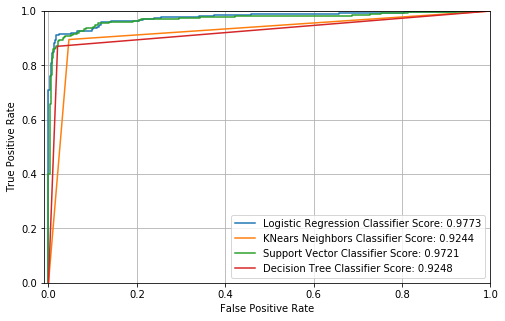

In [45]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
plt.figure(figsize=(8,5))
plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train,log_reg_pred) 

In [40]:
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 40)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 40)

# How it should look like
print('---' * 40)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 40)

------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.93
Precision Score: 0.79
F1 Score: 0.85
Accuracy Score: 0.85
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.80
Precision Score: 0.00
Recall Score: 0.19
F1 Score: 0.00
------------------------------------------------------------------------------------------------------------------------


In [41]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [42]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest,undersample_y_score)

print("Average Undersample Precision :{0:0.2f}".format(undersample_average_precision))

Average Undersample Precision :0.04


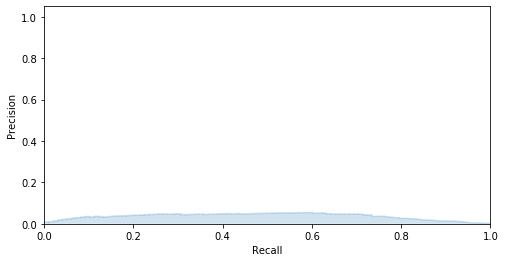

In [43]:
fig = plt.figure(figsize=(8,4))
precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)
plt.step(recall,precision,alpha=0.2,where='post')
plt.fill_between(recall,precision,step='post',alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [48]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV,train_test_split

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

log_reg_sm = LogisticRegression()

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
print('---'*40)    
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))    
print('---'*40)

------------------------------------------------------------------------------------------------------------------------
accuracy: 0.9490714060030637
precision: 0.06178124111896066
recall: 0.9137293086660175
f1: 0.11394060332100102
------------------------------------------------------------------------------------------------------------------------


In [49]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [50]:
y_score = best_est.decision_function(original_Xtest)

In [51]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.74


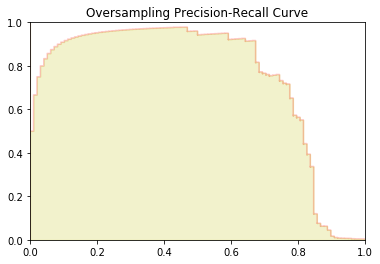

In [66]:
precision, recall,_ = precision_recall_curve(original_ytest,y_score)
plt.step(recall,precision,alpha=0.2,where='post',color='r')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.fill_between(recall,precision,step='post',alpha=0.2,color='y')
plt.title('Oversampling Precision-Recall Curve')
plt.show()

In [74]:
sm = SMOTE(sampling_strategy='minority',random_state=111)
Xsm_train, ysm_train= sm.fit_sample(original_Xtrain,original_ytrain)

In [76]:
t0=time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train,ysm_train)
t1=time.time()
print('Time for Fitting Oversample {}'.format(t1-t0))

Time for Fitting Oversample 4.915565490722656


In [78]:
from sklearn.metrics import classification_report,confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


print('Logistic Regression:')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_log_reg))
print('Classfication Report')
print(classification_report(y_test, y_pred_log_reg))
print('---'*40)

print('KNears Neighbors:')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_knear))
print('Classification Report')
print(classification_report(y_test, y_pred_knear))
print('---'*40)

print('Support Vector Classifier:')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_svc))
print('Classification Report')
print(classification_report(y_test, y_pred_svc))
print('---'*40)

print('Support Vector Classifier:')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_tree))
print('Classification Report')
print(classification_report(y_test, y_pred_tree))
print('---'*40)

Logistic Regression:
Confusion Matrix
[[90  2]
 [ 8 89]]
Classfication Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        92
           1       0.98      0.92      0.95        97

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

------------------------------------------------------------------------------------------------------------------------
KNears Neighbors:
Confusion Matrix
[[89  3]
 [10 87]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        92
           1       0.97      0.90      0.93        97

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.93      0.93      0.93       189

-----------------------------------------------------------------------

In [81]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.947090
1,Oversampling (SMOTE),0.987922


In [92]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])


In [93]:
undersample_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [94]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [98]:
undersample_model.fit(X_train, y_train, validation_split=0.2, epochs=20, shuffle=True, verbose=2)

Train on 601 samples, validate on 151 samples
Epoch 1/20
 - 0s - loss: 0.0654 - accuracy: 0.9750 - val_loss: 0.2764 - val_accuracy: 0.9338
Epoch 2/20
 - 0s - loss: 0.0630 - accuracy: 0.9750 - val_loss: 0.2785 - val_accuracy: 0.9272
Epoch 3/20
 - 0s - loss: 0.0605 - accuracy: 0.9784 - val_loss: 0.2811 - val_accuracy: 0.9272
Epoch 4/20
 - 0s - loss: 0.0585 - accuracy: 0.9784 - val_loss: 0.2884 - val_accuracy: 0.9272
Epoch 5/20
 - 0s - loss: 0.0564 - accuracy: 0.9784 - val_loss: 0.2934 - val_accuracy: 0.9272
Epoch 6/20
 - 0s - loss: 0.0546 - accuracy: 0.9800 - val_loss: 0.3015 - val_accuracy: 0.9272
Epoch 7/20
 - 0s - loss: 0.0527 - accuracy: 0.9817 - val_loss: 0.3052 - val_accuracy: 0.9272
Epoch 8/20
 - 0s - loss: 0.0507 - accuracy: 0.9817 - val_loss: 0.3075 - val_accuracy: 0.9272
Epoch 9/20
 - 0s - loss: 0.0488 - accuracy: 0.9850 - val_loss: 0.3136 - val_accuracy: 0.9272
Epoch 10/20
 - 0s - loss: 0.0467 - accuracy: 0.9850 - val_loss: 0.3188 - val_accuracy: 0.9272
Epoch 11/20
 - 0s - los

In [103]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=1)

56961/56961 [==============================] - 0s 5us/step


In [104]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=1)

56961/56961 [==============================] - 0s 5us/step


In [112]:
print(confusion_matrix(original_ytest,undersample_fraud_predictions))
print(classification_report(original_ytest,undersample_fraud_predictions))

[[54747  2116]
 [    5    93]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.95      0.08        98

    accuracy                           0.96     56961
   macro avg       0.52      0.96      0.53     56961
weighted avg       1.00      0.96      0.98     56961



In [106]:
no_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [107]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [108]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=200, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 6s - loss: 0.0522 - accuracy: 0.9814 - val_loss: 0.0158 - val_accuracy: 0.9990
Epoch 2/20
 - 6s - loss: 0.0093 - accuracy: 0.9980 - val_loss: 0.0044 - val_accuracy: 0.9998
Epoch 3/20
 - 6s - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0031 - val_accuracy: 0.9999
Epoch 4/20
 - 6s - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0101 - val_accuracy: 0.9999
Epoch 5/20
 - 6s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 6/20
 - 6s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 4.6737e-04 - val_accuracy: 1.0000
Epoch 7/20
 - 7s - loss: 0.0022 - accuracy: 0.9996 - val_loss: 4.7439e-04 - val_accuracy: 1.0000
Epoch 8/20
 - 7s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 4.2097e-04 - val_accuracy: 1.0000
Epoch 9/20
 - 7s - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0026 - val_accuracy: 0.9998
Epoch 10/20
 - 7s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 4.6973e-04 - val_accuracy: 1.0000
Ep

In [109]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [110]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [113]:
print(confusion_matrix(original_ytest,oversample_fraud_predictions))
print(classification_report(original_ytest,oversample_fraud_predictions))

[[56852    11]
 [   25    73]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.87      0.74      0.80        98

    accuracy                           1.00     56961
   macro avg       0.93      0.87      0.90     56961
weighted avg       1.00      1.00      1.00     56961

